In [1]:
%matplotlib inline

In [2]:
import time
import os
import sys
from collections import defaultdict
import json

import xml.etree.ElementTree as ET
from xml.dom import minidom

import numpy as np
import pandas as pd

import openslide
from PIL import Image
from PIL import ImageDraw

py_src_code_dir = '../src/python'
sys.path.insert(0, py_src_code_dir)
from digipath_toolkit import get_sample_selection_mask, get_strided_fence_array

data_dir = '../../DigiPath_MLTK_data'
zip_tank = '../../DigiPath_MLTK_data/zipTank/wsi_annotation_sample/'
xml_name = os.path.join(zip_tank, 'e39a8d60a56844d695e9579bce8f0335.xml')
c_lab_id_fn = os.path.join(zip_tank, 'class_label_id.csv')

im_dir = '../../DigiPath_MLTK_data/RegistrationDevData'
im_file = 'e39a8d60a56844d695e9579bce8f0335.tiff'
image_file_name = os.path.join(im_dir, im_file)


# Annotation: labeled patches from .xml, .csv, .svs
(and display all for developer sanity check)

## Convert xml & csv input to a region_id dict

## Create heirarchical mask set from the region_id dict

## Write labeled patches from the heirarchical mask set

```text
Questions:
    We should still create a threshold mask as before to omit any blank areas included in an annotation?
    Yes.
 
    When an entire label is eclipsed by a higher priority label (Empty) should the function issue a warning?
    No.
 
    The TFRecord could now have more than one “class_label” and,
    the “label” field that TFRecord owns is still just a sequence number… 
    thus it may be more difficult to select training/test subsets.
    Ergo: should each “class_label” aka “class_label_text” be in a different TFRecord file?
    No - one file is fine
```

## Givin a WSI, an Annotation File and an Annotation Labels priority dictionary file

1) Annotation file must follow the QuPath Annotation convention. <br>
2) Labels dictionary required to assign priority. <br>
****
```python
# read the Annotation File and the labels priority dict into a regions dictionary:
# read the regions dictionary into a labels dict
#    for each label
#        get the mask,
#        add the patches to the tfrecord or write the files,

```

### Issue: thumbnail_divisor too large makes patch test smaller than one pixel.

In [28]:
"""
from collections import defaultdict
import json

from xml.dom import minidom

import openslide

from PIL import Image
from PIL import ImageDraw
"""

def get_labels_dict(class_labels_id_file_name):
    """ labels_dict = get_labels_dict(class_labels_id) 
    Args:
        class_labels_id_file_name:  .csv file with columns [Label, ID, Priority]
    Returns:
        labels_dict:                python dict of dicts:
                                        {label_id_(n): {ID: x, Priority: y}, ...}
    """
    # allocate dict of dicts
    labels_dict = defaultdict(dict)
    
    # read the file
    lines = ''
    try:        
        with open(class_labels_id_file_name, 'r') as fh:
            lines = fh.readlines()
    except:
        print('failed opening: ', class_labels_id_file_name)
        lines = ''
        pass
    
    # read the lines into the dict
    if len(lines) > 0:
        for line in lines:
            line_list = line.strip().split(',')
            if len(line_list) > 1 and line_list[0] != 'Label':
                labels_dict[line_list[0]] = {'ID': line_list[1], 'Priority': line_list[1]}
                
    return labels_dict


def get_xml_list_of_dicts(xml_file_name):
    """ regions_list = get_xml_list_of_dicts(xml_file_name) 
    Args:
        xml_file_name:  required TagName
                            Vertex
                        required Attributes
                            Id
                            Text
                            Type
                            GeoShape
    Returns:
        regions_list:   list of dicts with keys:
                            region_Id
                            class_label_text
                            class_label_Id
                            region_geo_shape
                            coords
    """
    
    xml_obj = minidom.parse(xml_file_name)
    regions_dom = xml_obj.getElementsByTagName("Region")

    regions_list = []
    for reg_dom in regions_dom:
        tmp_dict = {}
        vertices = reg_dom.getElementsByTagName("Vertex")
        tmp_dict['region_Id'] = reg_dom.getAttribute('Id')
        tmp_dict['class_label_text'] = reg_dom.getAttribute('Text')
        tmp_dict['class_label_Id'] = reg_dom.getAttribute('Type')
        tmp_dict['region_geo_shape'] = reg_dom.getAttribute('GeoShape')
        tmp_dict['coords'] = np.zeros((len(vertices), 2))
        for i, vertex in enumerate(vertices):
            tmp_dict['coords'][i][0] = vertex.attributes['X'].value
            tmp_dict['coords'][i][1] = vertex.attributes['Y'].value
            
        regions_list.append(tmp_dict)
        
    return regions_list


def get_region_Id_dict(xml_file_name, class_labels_id_file_name):
    """ region_id_dict = get_region_Id_dict(xml_file_name, class_labels_id_file_name) 
    """
    # read the xml file into a list of dicts
    regions_list = get_xml_list_of_dicts(xml_file_name)
    
    # read the csv file into a dict of dicts Label: {ID: x, Priority: y}
    label_dict = get_labels_dict(class_labels_id_file_name)
    
    # initialize the output dictionary
    region_id_dict = defaultdict(dict)
    
    # enter each region into the output dict
    for region_dict in regions_list:
        # extract and cast the region Priority from the csv file
        region_priority = int(label_dict[region_dict['class_label_text']]['Priority'])
        
        # construct the rest of the region dict from the xml file
        ridic = {'class_label_text': region_dict['class_label_text'], 
                 'class_label_Id': region_dict['class_label_Id'], 
                 'Priority': region_priority, 
                 'region_geo_shape': region_dict['region_geo_shape'], 
                 'coords': region_dict['coords']}
        
        region_id_dict[int(region_dict['region_Id'])] = ridic
        
    return region_id_dict

def regions_dict_to_labels_dict(regions_dict):
    """ labels_dict =   regions_dict_to_labels_dict(regions_dict) 
                        convert a regions_id_dict to a labels dict with data preserved
    
    Args:
        regions_dict:   such as returned by get_region_Id_dict(xml_file, csv_labels)
        
    Returns:
        labels_dict:    same data with labels as keys to list of regions dicts
    """
    labels_dict = defaultdict(list)
    for k_reg_id, reg_dict in regions_dict.items():
        reg_dict['region_Id'] = k_reg_id
        labels_dict[reg_dict['class_label_text']].append(reg_dict)
        
    return labels_dict


def regions_dict_to_priority_dict(regions_dict):
    """ priority_dict, priority_list =   regions_dict_to_labels_dict(regions_dict) 
                        convert a regions_id_dict to a labels dict with data preserved
    
    Args:
        regions_dict:   such as returned by get_region_Id_dict(xml_file, csv_labels)
        
    Returns:
        priority_dict:    same data with labels as keys to list of regions dicts
        priority_list:    ordered highest to lowest (largest)
    """
    priority_list = []
    priority_dict = defaultdict(list)
    for k_reg_id, reg_dict in regions_dict.items():
        reg_dict['region_Id'] = k_reg_id
        priority_dict[reg_dict['Priority']].append(reg_dict)
        priority_list.append(reg_dict['Priority'])
        
    priority_list = sorted(priority_list, reverse=True)
        
    return priority_dict, priority_list


def get_region_mask(region_coords, thumbnail_divisor, image_dimensions):
    """ mask_im, img = get_region_mask(region_coords, thumbnail_divisor,image_dimensions) 
    """
    # scale the region coords with the thumbnail_divisor, 
    # convert to a list of tuples of type int
    xy_list = (region_coords / thumbnail_divisor).astype(np.int).tolist()
    xy_list = [(p[0], p[1]) for p in xy_list ]
    
    # create a (black) thumbnail of the full-size image scaled with the thumbnail_divisor
    thumbnail_size = tuple((np.array(image_dimensions)/thumbnail_divisor).astype(np.int))
    num_thumb_size = (thumbnail_size[1], thumbnail_size[0])
    img = Image.fromarray(np.zeros(num_thumb_size).astype(np.uint8))
    
    # make it a Pillow Draw and draw the polygon from the list of (x,y) tuples
    draw = ImageDraw.Draw(img)
    draw.polygon(xy_list, fill="white")
    
    # create the logical mask for patch selection
    mask_im = np.array(img) > 0
    
    return mask_im, img

def get_mask_for_label(lbl_dict_list, thumbnail_divisor, image_dimensions):
    """ label_mask = get_mask_for_label(lbl_dict_list, thumbnail_divisor, image_dimensions)
    """
    lbl_mask = None
    #     for lbl, lbl_dict_list in labels_dict.items():
    for lbl_dict in lbl_dict_list:
        region_coords = lbl_dict['coords']
        mask_im, img = get_region_mask(region_coords,thumbnail_divisor,image_dimensions)
        if lbl_mask is None:
            lbl_mask = mask_im
        else:
            lbl_mask += mask_im
                
    lbl_mask[lbl_mask > 0] = 1
    
    return lbl_mask


def get_labeled_masks(run_parameters):
    """ Usage: labeled_masks_dict = get_labeled_masks_dict(run_parameters)
    Prioritized dictionary for each region defined in the input xml and csv
    
    {label: patch_selection_mask, ... } 
    
    Args:
        run_parameters:             with keys:
                                        csv_file_name
                                        xml_file_name
                                        thumbnail_divisor
                                        wsi_filename
                                    
    Returns:
        heirarchical_mask_dict:     {label_1: mask_image, ...}
        
    """  
    # assign local names
    labeled_masks_dict = dict()
    csv_file_name = run_parameters['csv_file_name']
    xml_file_name = run_parameters['xml_file_name']
    thumbnail_divisor = run_parameters['thumbnail_divisor']
    patch_select_method = run_parameters['patch_select_method']
    wsi_filename = run_parameters['wsi_filename']
    
    # get the priority dict and list of what is in it
    regions_dict = get_region_Id_dict(xml_file_name, csv_file_name)
    priority_dict, priority_list = regions_dict_to_priority_dict(regions_dict)
    
    #       initialize the priority mask
    os_im_obj = openslide.OpenSlide(wsi_filename)
    image_dimensions = os_im_obj.dimensions
    thumbnail_size = (image_dimensions[0] // thumbnail_divisor, image_dimensions[1] // thumbnail_divisor)
    small_im = os_im_obj.get_thumbnail(thumbnail_size)
    os_im_obj.close()

    higher_priorities_mask =get_sample_selection_mask(small_im, patch_select_method, run_parameters=None)    
    
    # iterate the priority dict into the heirarchical mask set 
    # -- subtracting all higher priority masks from the new lower ones
    for p in priority_list:
        p_dict_list = priority_dict[p]
        labels_list = []
        for p_dict in p_dict_list:
            label = p_dict['class_label_text']
            if label in labels_list:
                print('Dire Warning: More than one label with same priority')
            labels_list.append(label)
            
        labeled_masks_dict[label] = get_mask_for_label(p_dict_list, thumbnail_divisor, image_dimensions)
        if higher_priorities_mask is None:
            higher_priorities_mask = labeled_masks_dict[label]
        else:
            this_mask = np.logical_and(np.logical_not(higher_priorities_mask), labeled_masks_dict[label])
            if this_mask.sum() > 0:
                labeled_masks_dict[label] = this_mask
                higher_priorities_mask = np.logical_or(labeled_masks_dict[label], higher_priorities_mask)
            
    return labeled_masks_dict


def get_select_bounds_from_mask(mask_mat, xy='x'):
    """ Usage: start_stop_dict = get_select_bounds_from_mask(mask_mat, xy='x')
    find the first and last unmasked row (y) or col (x) in the mask image input mask_mat
    
    Args:
        mask_mat:           2d numpy binary array
        xy:                 character x for x axis or y for y axis
        
    Returns:
        start_stop_dict:    {xy+'_start': _start_, xy+'_end': _stop_}
        
    """
    # initialize
    _start_ = None
    _stop_ = None
    
    # translate input variables
    if xy == 'x':
        axis = 1
        
    elif xy == 'y':
        axis = 0
        
    # sum of axis: sum_of_rows is x, axis=1,
    sum_of_axis = mask_mat.sum(axis=axis)
    current_greater_than = 0
    for k in range(sum_of_axis.size):
        if sum_of_axis[k] > 0:
            current_greater_than = k
            if _start_ is None:
                _start_ = k
    
    # set the last row if a first row one more were found to contain ones
    if not _start_ is None and current_greater_than > _start_:
        _stop_ = current_greater_than
    
    # cover the all the way to the include all cases
    if _start_ is None:
        _start_ = 0
        
    if _stop_ is None:
        _stop_ = k
        
    # name the return values with the expected x, y input
    start_stop_dict = {xy+'_start': _start_, xy+'_end': _stop_}
    
    return start_stop_dict

In [58]:
"""
        next
        
"""
MIN_PATCH_SIZE = 1
def get_patch_location_array_from_annotations(run_parameters):
    """ Usage:  _ = get_patch_location_array_from_annotations(run_parameters)
    
    """
    thumbnail_divisor = run_parameters['thumbnail_divisor']
    patch_height = max(MIN_PATCH_SIZE, run_parameters['patch_height'] // thumbnail_divisor)
    patch_width = max(MIN_PATCH_SIZE, run_parameters['patch_width'] // thumbnail_divisor)
    
    if 'patch_stride_fraction' in run_parameters:
        patch_stride = run_parameters['patch_stride_fraction']
    else:
        patch_stride = 1.0
    
    labeled_masks_dict = get_labeled_masks(run_parameters)
    labeled_annotation_arrays_dict = defaultdict(dict)
    for label_name, mask_mat in labeled_masks_dict.items():
        start_stop_rows = get_select_bounds_from_mask(mask_mat, xy='y')
        row_start, row_end = start_stop_rows['y_start'], start_stop_rows['y_end']
        rows_fence_array = get_strided_fence_array(patch_height, patch_stride, row_start, row_end)
        labeled_annotation_arrays_dict[label_name]['rows_fence_array'] = rows_fence_array
        
        start_stop_cols = get_select_bounds_from_mask(mask_mat, xy='x')
        col_start, col_end = start_stop_cols['x_start'], start_stop_cols['x_end']
        cols_fence_array = get_strided_fence_array(patch_width, patch_stride, col_start, col_end)
        labeled_annotation_arrays_dict[label_name]['cols_fence_array'] = cols_fence_array
        
    # for each mask get the start-stop bounds, get the strided patch fence array
    #  & add those keys to another label-keyed dict
    
    data_dict = {'labeled_masks_dict': labeled_masks_dict, 
                 'labeled_annotation_arrays_dict': labeled_annotation_arrays_dict}
    return data_dict
        
data_dir = '../../DigiPath_MLTK_data'
output_dir = '../../DigiPath_MLTK_data/annotation_test/results'
if os.path.isdir(output_dir) == False:
    os.makedirs(output_dir)

wsi_file = 'RegistrationDevData/e39a8d60a56844d695e9579bce8f0335.tiff'
wsi_file = os.path.join(data_dir, wsi_file)
csv_file = 'wsi_annotation_sample/class_label_id.csv'
csv_file = os.path.join(data_dir, csv_file)
xml_file = 'wsi_annotation_sample/e39a8d60a56844d695e9579bce8f0335.xml'
xml_file = os.path.join(data_dir, xml_file)

run_parameters = {'method': 'annotations_to_dir', 
                  'output_dir': output_dir,
                  'wsi_filename': wsi_file, 
                  'csv_file_name': csv_file,
                  'xml_file_name': xml_file,
                  'thumbnail_divisor': 100, 
                  'patch_stride_fraction': 1.0, 
                  'image_level': 1.0, 
                  'patch_select_method': 'annotation_xml', 
                  'patch_height': 224, 
                  'patch_width': 224, 
                  'threshold': 0, 
                  'patch_select_method': 'threshold_rgb2lab', 
                  'rgb2lab_threshold': 80}

data_dict = get_patch_location_array_from_annotations(run_parameters)
labeled_arrays_dict = data_dict['labeled_annotation_arrays_dict']
labeled_masks = data_dict['labeled_masks_dict']
for k, v in labeled_masks.items():
    rows = len(labeled_arrays_dict[k]['rows_fence_array'])
    cols = len(labeled_arrays_dict[k]['cols_fence_array'])
    print(k, type(v), 'rows %i, cols %i'%(rows, cols))
    

normal <class 'numpy.ndarray'> rows 34, cols 21
ink <class 'numpy.ndarray'> rows 87, cols 40
offset <class 'numpy.ndarray'> rows 278, cols 148
malignant <class 'numpy.ndarray'> rows 36, cols 21
Region <class 'numpy.ndarray'> rows 306, cols 204
lymph <class 'numpy.ndarray'> rows 40, cols 42
fat <class 'numpy.ndarray'> rows 16, cols 31
null <class 'numpy.ndarray'> rows 60, cols 33


In [54]:
labeled_masks_dict = data_dict['labeled_masks_dict']
patch_height = 224 // run_parameters['thumbnail_divisor']
patch_width =  224 // run_parameters['thumbnail_divisor']
patch_stride = run_parameters['patch_stride_fraction']
print('patch_width, patch_height', patch_width, patch_height)
MIN_STRIDE_PIXELS = 1
patch_stride = max(patch_stride, (MIN_STRIDE_PIXELS / min(patch_width, patch_height) ) )
print(patch_stride, '\n')
for label_name, mask_mat in labeled_masks_dict.items():
    start_stop_rows = get_select_bounds_from_mask(mask_mat, xy='y')
    row_start, row_end = start_stop_rows['y_start'], start_stop_rows['y_end']
    rows_fence_array = get_strided_fence_array(patch_height, patch_stride, row_start, row_end)
    
    
    start_stop_cols = get_select_bounds_from_mask(mask_mat, xy='x')
    col_start, col_end = start_stop_cols['x_start'], start_stop_cols['x_end']
    #print(label_name+'_cols', col_start, col_end)
    
    print(label_name, mask_mat.shape, row_start, row_end, len(cols_fence_array),
          '\t_cols', col_start, col_end, len(cols_fence_array))
    
    cols_fence_array = get_strided_fence_array(patch_width, patch_stride, col_start, col_end)

patch_width, patch_height 1 1
1.0 

normal (378, 634) 271 305 34 	_cols 163 184 34
ink (378, 634) 80 148 21 	_cols 129 166 21
offset (378, 634) 98 375 37 	_cols 75 224 37
malignant (378, 634) 152 186 149 	_cols 85 105 149
Region (378, 634) 26 333 20 	_cols 29 233 20
lymph (378, 634) 167 207 204 	_cols 105 147 204
fat (378, 634) 53 69 42 	_cols 52 84 42
null (378, 634) 246 307 32 	_cols 190 224 32


In [5]:
# Test start_stop_dict = get_select_bounds_from_mask(mask_mat, xy='x')
A = labeled_masks['normal']
print('Input mask shape', A.shape)
print('\n\t(down) sum of rows array shape:', A.sum(axis=1).shape, 
      '\n\t(right) sum of cols array shape:', A.sum(axis=0).shape)
sum_of_rows = A.sum(axis=1)
first_row = None
last_row = None

print("\nnon-zero row numbers: ")
for k in range(sum_of_rows.size):
    if sum_of_rows[k] > 0:
        current_greater_than = k
        if first_row is None:
            first_row = k
        print(k)
    
if not first_row is None and current_greater_than > first_row:
    last_row = current_greater_than
print('\n')
print(first_row, last_row)

print('\n\nUsing function: get_select_bounds_from_mask\n')
mask_mat = labeled_masks['normal']
start_stop_dict = get_select_bounds_from_mask(mask_mat, xy='x')
for k, v in start_stop_dict.items():
    print(k, v)
print('\n')
start_stop_dict = get_select_bounds_from_mask(mask_mat, xy='y')
for k, v in start_stop_dict.items():
    print(k, v)

Input mask shape (378, 634)

	(down) sum of rows array shape: (378,) 
	(right) sum of cols array shape: (634,)

non-zero row numbers: 
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
182
183
184


163 184


Using function: get_select_bounds_from_mask

x_start 163
x_end 184


y_start 271
y_end 305


mask for normal


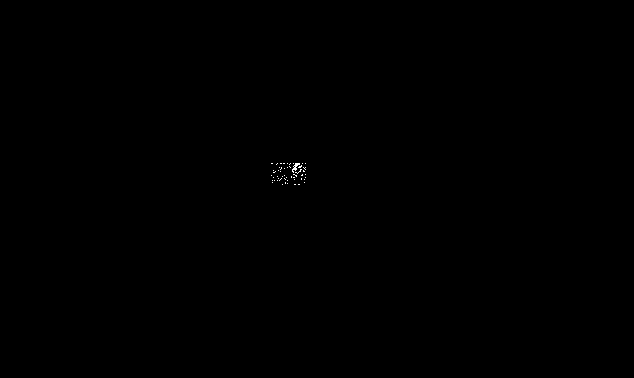

null (378, 634) 271 305 


mask for ink


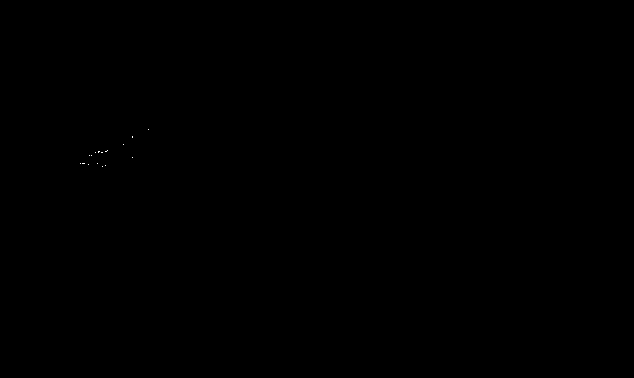

null (378, 634) 271 305 


mask for offset


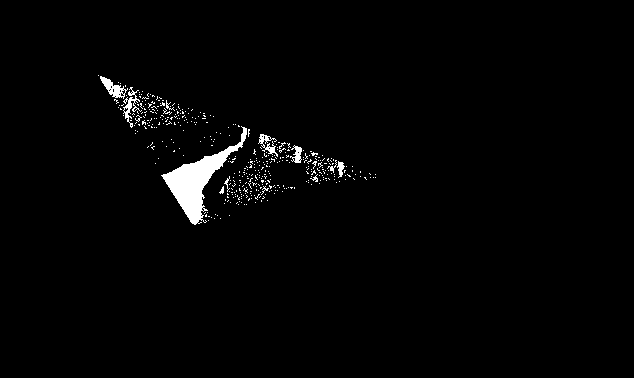

null (378, 634) 271 305 


mask for malignant


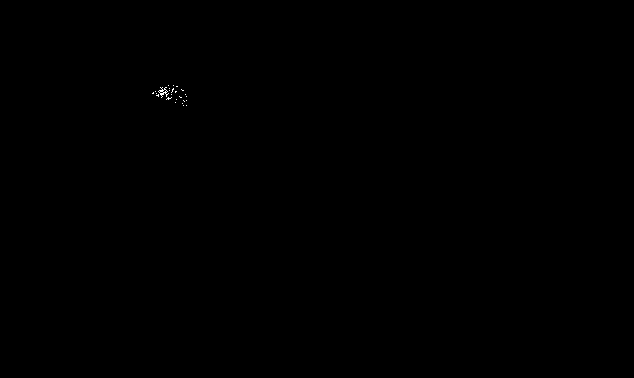

null (378, 634) 271 305 


mask for Region


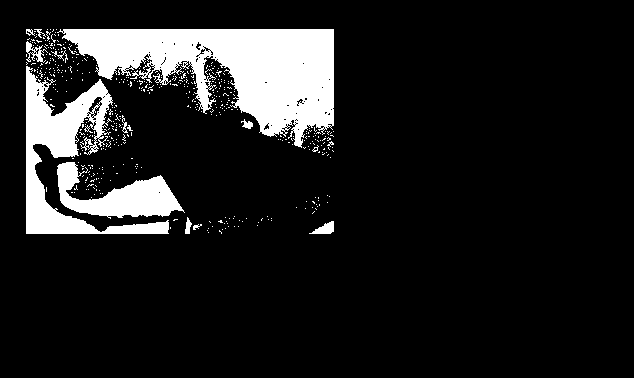

null (378, 634) 271 305 


mask for lymph


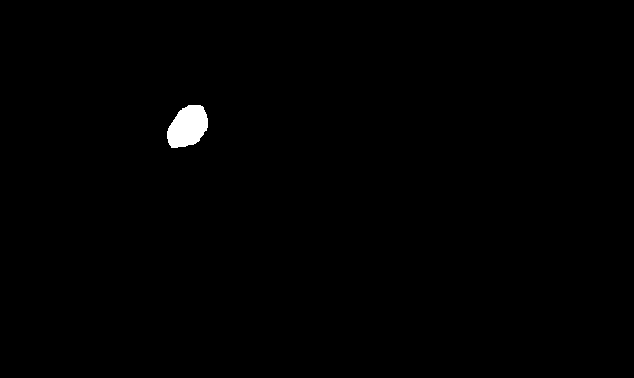

null (378, 634) 271 305 


mask for fat


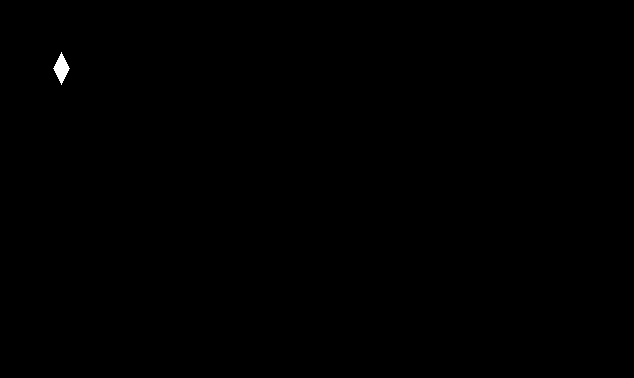

null (378, 634) 271 305 


mask for null


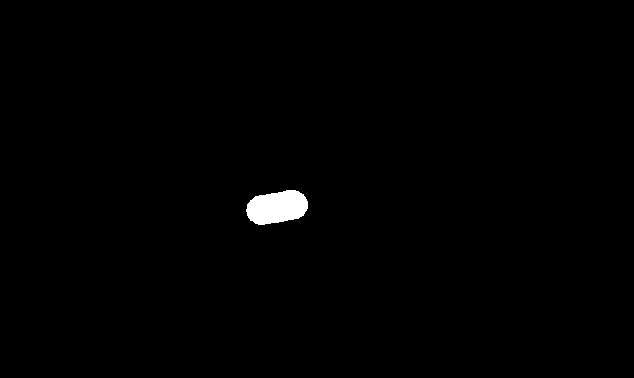

null (378, 634) 271 305 


total run time: 0.167


In [27]:
"""
        Test function: get_labeled_masks(run_parameters)
        
        Expected - one labeled mask per priority level unless mask is blank
        
"""
t0 = time.time()
labeled_masks_dict = get_labeled_masks(run_parameters)

for merge_label, merged_lbl_msk in labeled_masks_dict.items():
    if merged_lbl_msk.sum() == 0:
        print(merge_label, 'Is Empty Mask')
    else:
        m_lbl_im = Image.fromarray((merged_lbl_msk.astype(np.uint8) * 255))
        print('mask for %s'%(merge_label))
        display(m_lbl_im)
        
        start_stop_rows = get_select_bounds_from_mask(merged_lbl_msk, xy='y')
        row_start, row_end = start_stop_rows['y_start'], start_stop_rows['y_end']
        rows_fence_array = get_strided_fence_array(patch_height, patch_stride, row_start, row_end)
        print(label_name, merged_lbl_msk.shape, row_start, row_end, '\n\n')
    
print('total run time: %0.3f'%(time.time() - t0))

# Review-test notebook implemented functions:

mask for normal


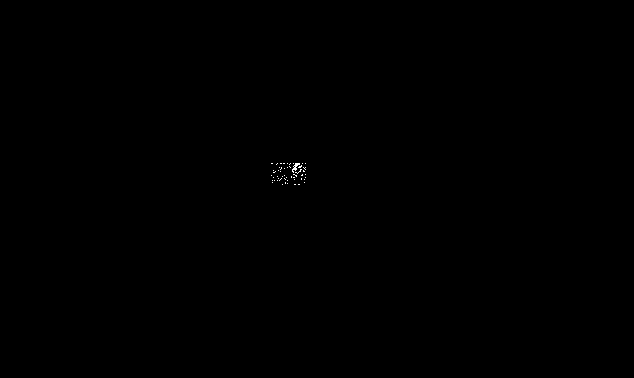

mask for ink


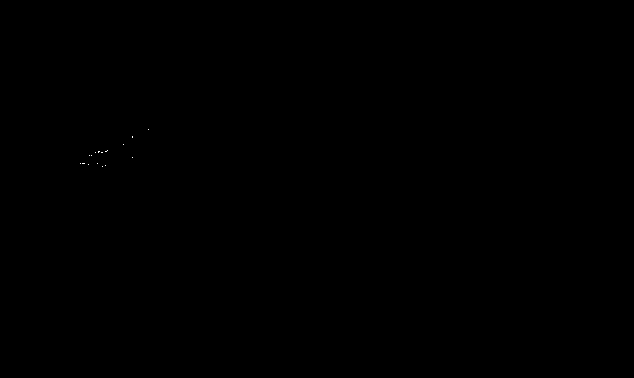

mask for offset


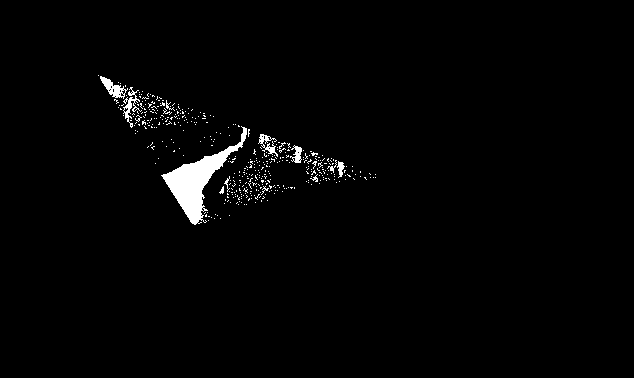

mask for malignant


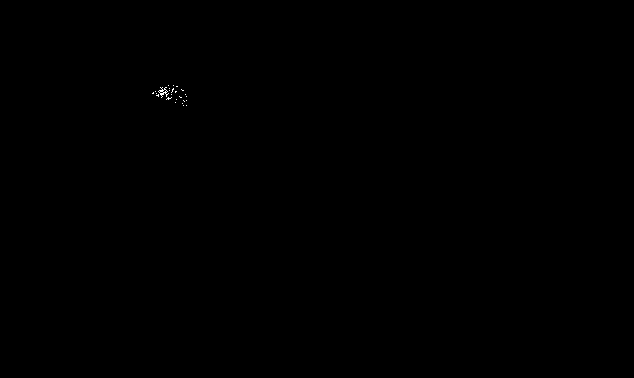

mask for Region


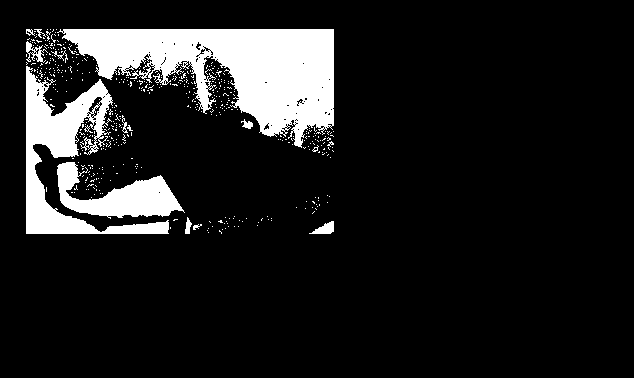

mask for lymph


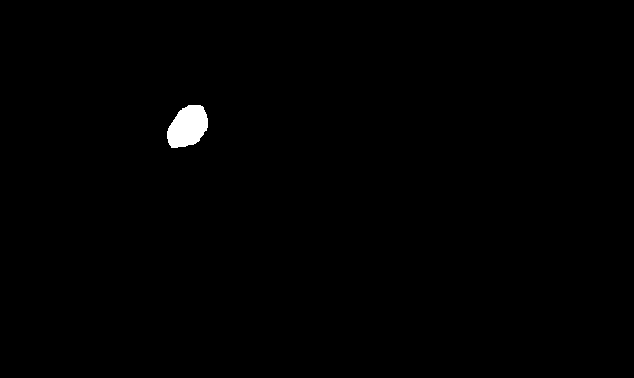

mask for fat


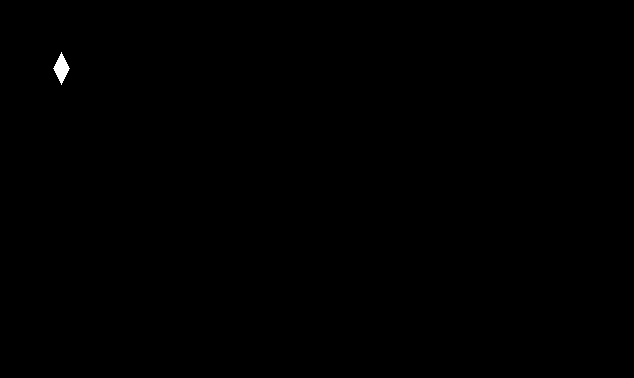

mask for null


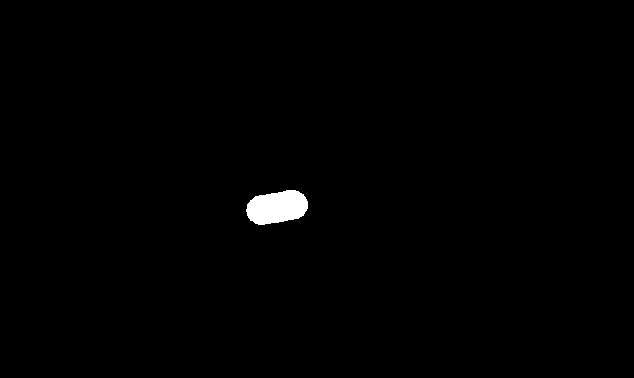

total run time: 0.215


In [6]:
"""
        Test function: get_labeled_masks(run_parameters)
        
        Expected - one labeled mask per priority level unless mask is blank
        
"""
t0 = time.time()
labeled_masks_dict = get_labeled_masks(run_parameters)

for merge_label, merged_lbl_msk in labeled_masks_dict.items():
    if merged_lbl_msk.sum() == 0:
        print(merge_label, 'Is Empty Mask')
    else:
        m_lbl_im = Image.fromarray((merged_lbl_msk.astype(np.uint8) * 255))
        print('mask for %s'%(merge_label))
        display(m_lbl_im)
    
print('total run time: %0.3f'%(time.time() - t0))

In [7]:
"""
        Test - demo            regions_dict = get_region_Id_dict(xml_name, c_lab_id_fn)

        Test - demo            priority_dict, priority_list= regions_dict_to_priority_dict(regions_dict)

Note that in this test set (xml, csv) there is only one class label per priority level
"""
regions_dict = get_region_Id_dict(xml_name, c_lab_id_fn)
priority_dict, priority_list = regions_dict_to_priority_dict(regions_dict)

for p in priority_list:
    lbl_dict_list = priority_dict[p]
    print('\nPriority:', p, '\t(%i dictionaries)'%(len(lbl_dict_list)))
    for lbl_dict in lbl_dict_list:
        for k, v in lbl_dict.items():
            if isinstance(v, np.ndarray):
                print('%20s:'%(k), v[0,:])
                for v_ix in range(len(v) - 1):
                    print('%20s '%(' '), v[v_ix+1,:])
            else:
                print('%20s:'%(k), v)


Priority: 7 	(1 dictionaries)
    class_label_text: normal
      class_label_Id: 7
            Priority: 7
    region_geo_shape: Rectangle
              coords: [54263.393564 32703.707487]
                      [61076.004787 32703.707487]
                      [61076.004787 36961.589501]
                      [54263.393564 36961.589501]
           region_Id: 4

Priority: 6 	(1 dictionaries)
    class_label_text: ink
      class_label_Id: 6
            Priority: 6
    region_geo_shape: Area
              coords: [33423.445313 25154.421875]
                      [33309.050781 25268.814453]
                      [33194.65625  25268.814453]
                      [33080.265625 25383.207031]
                      [32965.871094 25383.207031]
                      [32794.28125  25554.794922]
                      [32737.085938 25497.599609]
                      [32737.085938 25383.207031]
                      [32622.693359 25497.599609]
                      [32508.300781 25497.599609]
    

                      [32393.908203 27785.455078]
                      [32851.480469 27785.455078]
                      [32965.871094 27671.0625  ]
                      [33309.050781 27671.0625  ]
                      [33423.445313 27556.669922]
                      [33652.230469 27556.669922]
                      [33766.621094 27442.277344]
                      [34452.980469 27442.277344]
                      [34567.371094 27556.669922]
                      [34681.765625 27556.669922]
                      [34796.15625 27671.0625 ]
                      [35253.726563 28128.632813]
                      [35368.121094 28128.632813]
                      [35596.90625  28357.419922]
                      [35825.691406 28357.419922]
                      [35711.300781 28243.027344]
                      [35253.726563 27785.453125]
                      [35253.726563 27671.0625  ]
                      [35139.335938 27556.671875]
                      [35139.335938 27556.669922]
  

                      [28504.552734 23495.724609]
                      [28504.552734 23381.332031]
           region_Id: 3

Priority: 3 	(1 dictionaries)
    class_label_text: Region
      class_label_Id: 3
            Priority: 3
    region_geo_shape: Rectangle
              coords: [5302.716542 5820.451   ]
                      [66617.253479  5820.451   ]
                      [66617.253479 46773.07082 ]
                      [ 5302.716542 46773.07082 ]
           region_Id: 2

Priority: 2 	(1 dictionaries)
    class_label_text: lymph
      class_label_Id: 2
            Priority: 2
    region_geo_shape: Polygon
              coords: [33423.445313 27499.472656]
                      [33423.445313 27385.080078]
                      [33423.445313 27270.6875  ]
                      [33423.445313 27041.902344]
                      [33423.445313 26927.509766]
                      [33423.445313 26813.117188]
                      [33423.445313 26584.330078]
                      [3342